# House Rent Prediction - KNN

## Imports

In [448]:
# Utilities
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns

# Scipy
from scipy.stats import boxcox

# SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dataset
import kagglehub
path = kagglehub.dataset_download("iamsouravbanerjee/house-rent-prediction-dataset")
dataset = pd.read_csv(f"{path}\\House_Rent_Dataset.csv")

# Definição da Seed
seed = 42

## Análise Exploratório de Dados

In [449]:
dataset.shape

(4746, 12)

In [450]:
print("Number of row: ", dataset.shape[0])
print("Number of columns: ", dataset.shape[1])

Number of row:  4746
Number of columns:  12


In [451]:
# Checking for missing values
dataset.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [452]:
dataset.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

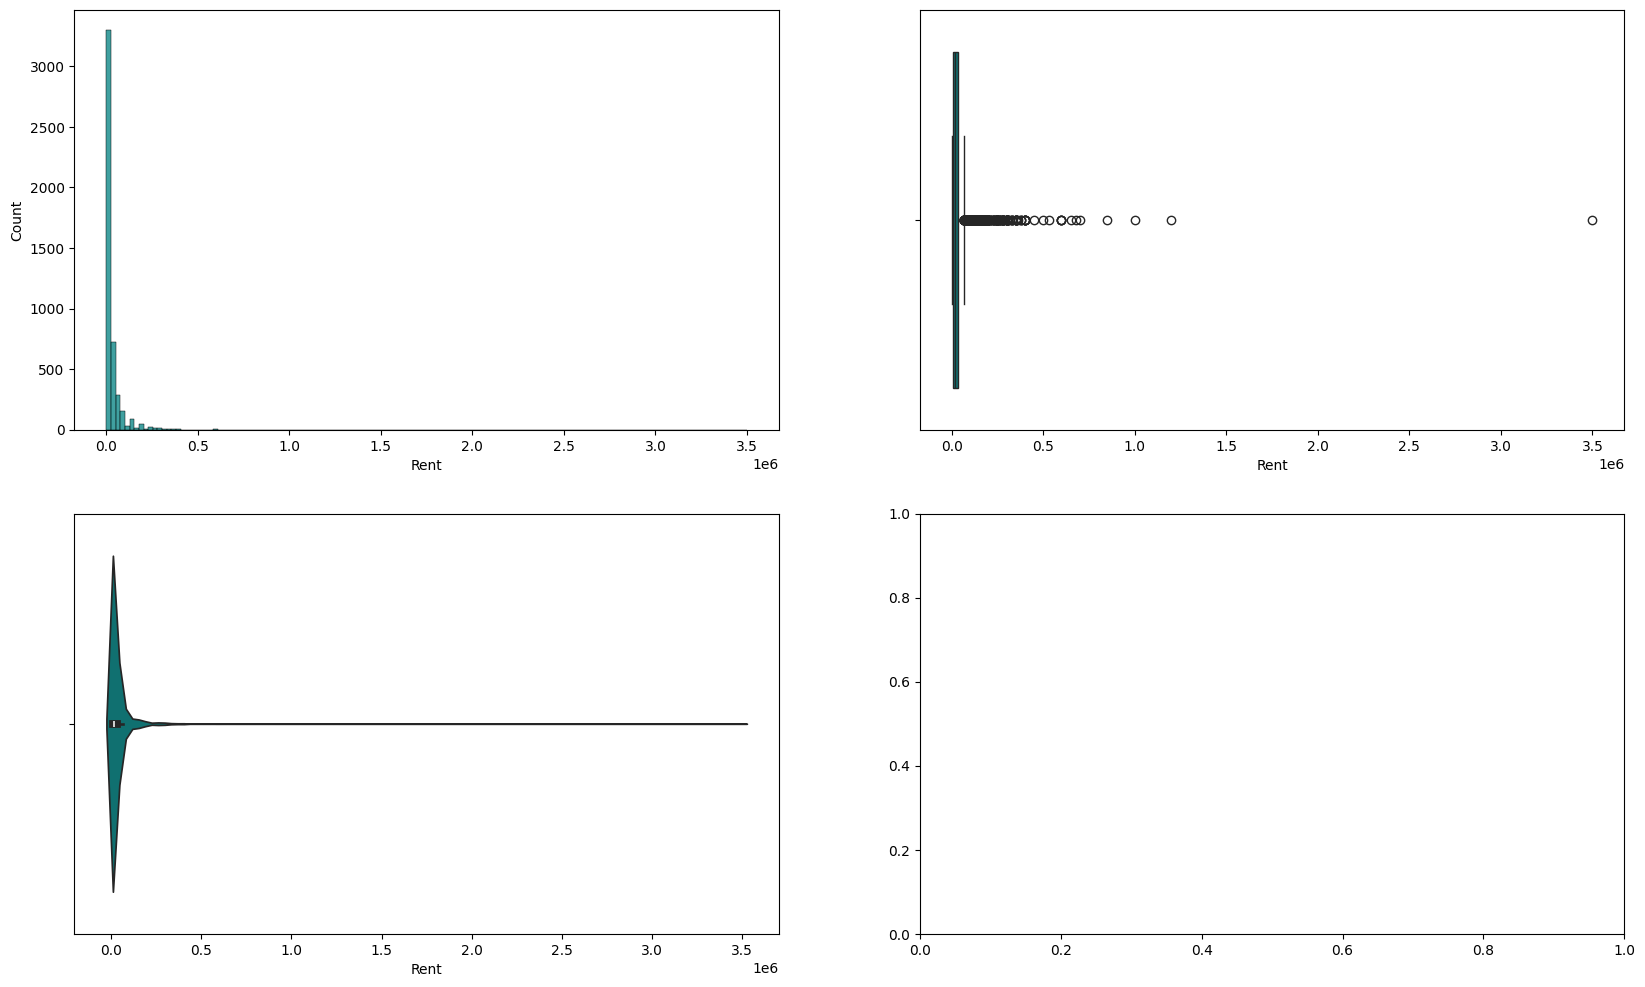

In [453]:
# Rent - Our target column

fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Rent'], ax= ax[0, 1], color= 'teal') # entender bem como funciona esse para a gent explicar
ax3 = sns.violinplot(x = dataset['Rent'], ax= ax[1, 0], color= 'teal')

plt.show()

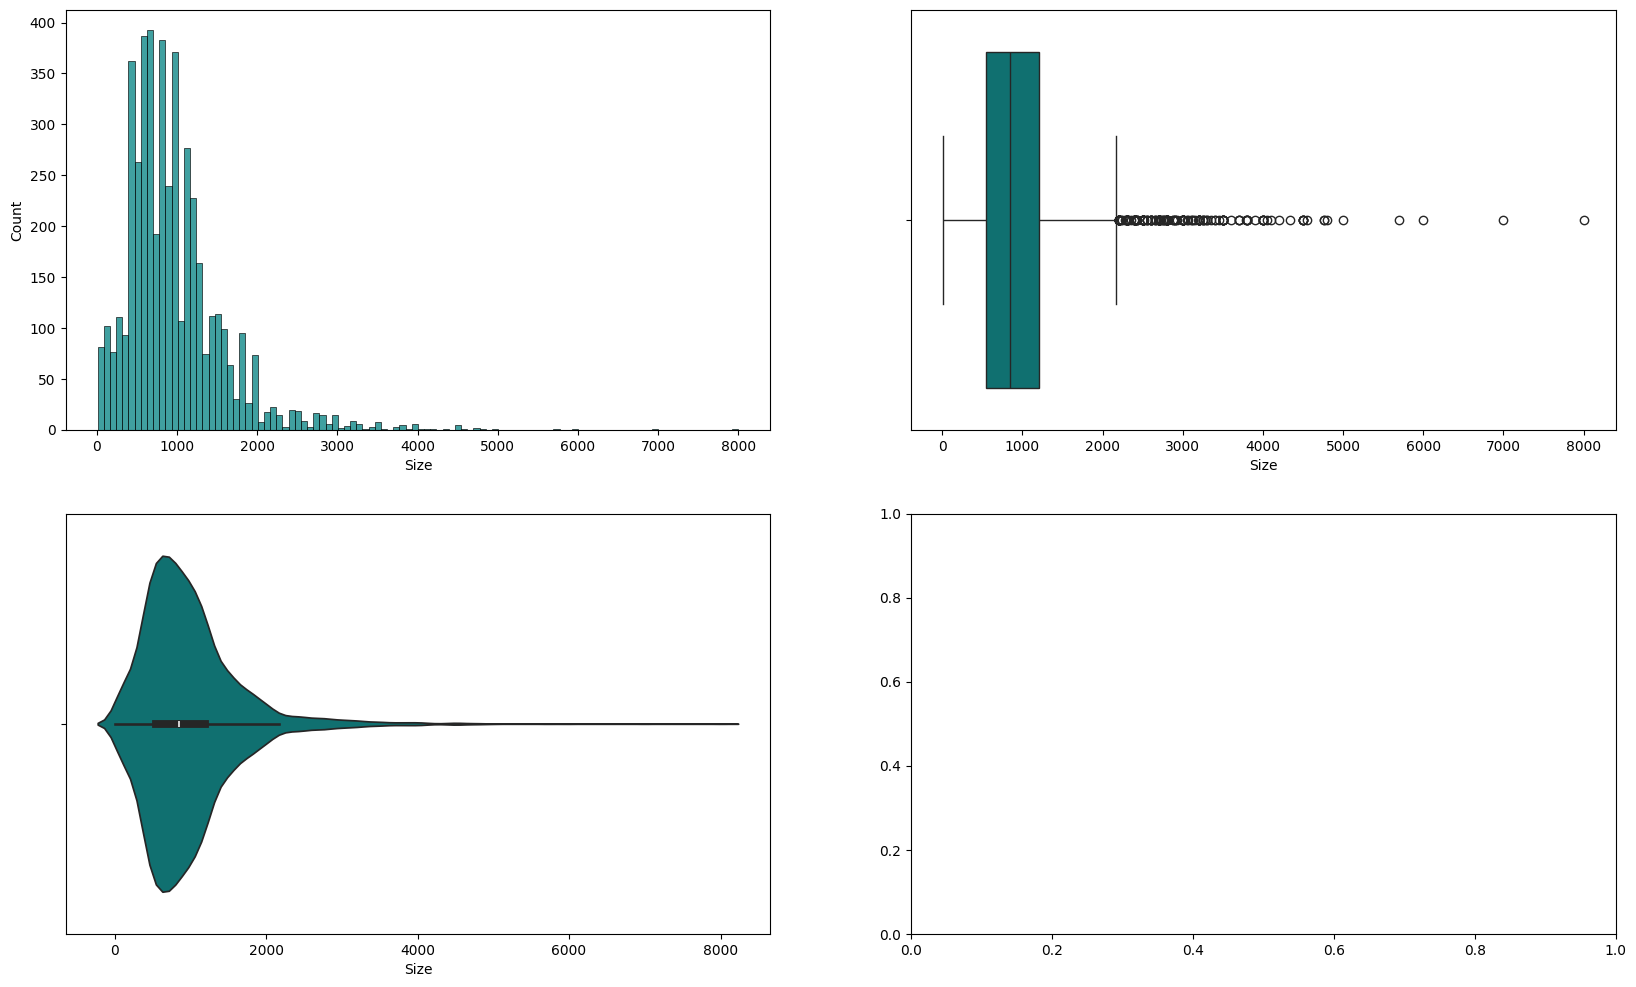

In [454]:
# Size

ig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Size'], ax= ax[1, 0], color= 'teal')
plt.show()

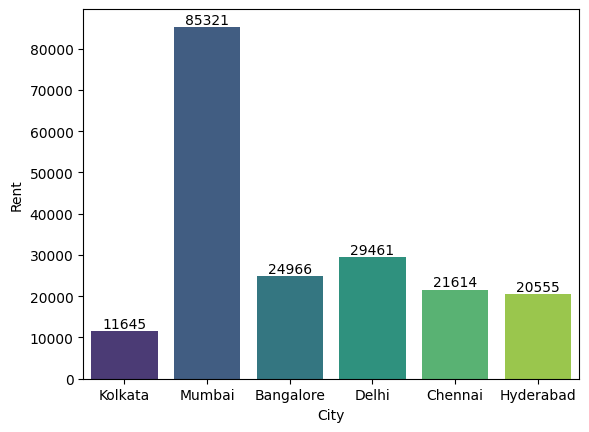

<Figure size 1500x700 with 0 Axes>

In [455]:
# City

ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'], 
                 palette='viridis',
                 hue=dataset['City'],
                 legend=False,
                 errorbar = None)
plt.ylabel('Rent')
plt.figure(figsize=(15, 7))

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

## Pré Processamento

In [ ]:
# Based on this analysis we can confirm there's some columns that are not interesting for our algorithm (explain why?)
# Such as: Posted On, Floor, Area Locality, City, Tenant Preferred e Point of Contact

# We can remove those columns for prevent our dataset to have many...

dataset = dataset.drop(['Posted On', 'Floor', 'Area Locality'], axis=1)
dataset.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Bathroom
0,2,10000,1100,Super Area,Kolkata,Unfurnished,2
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,1
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,1
3,2,10000,800,Super Area,Kolkata,Unfurnished,1
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,1


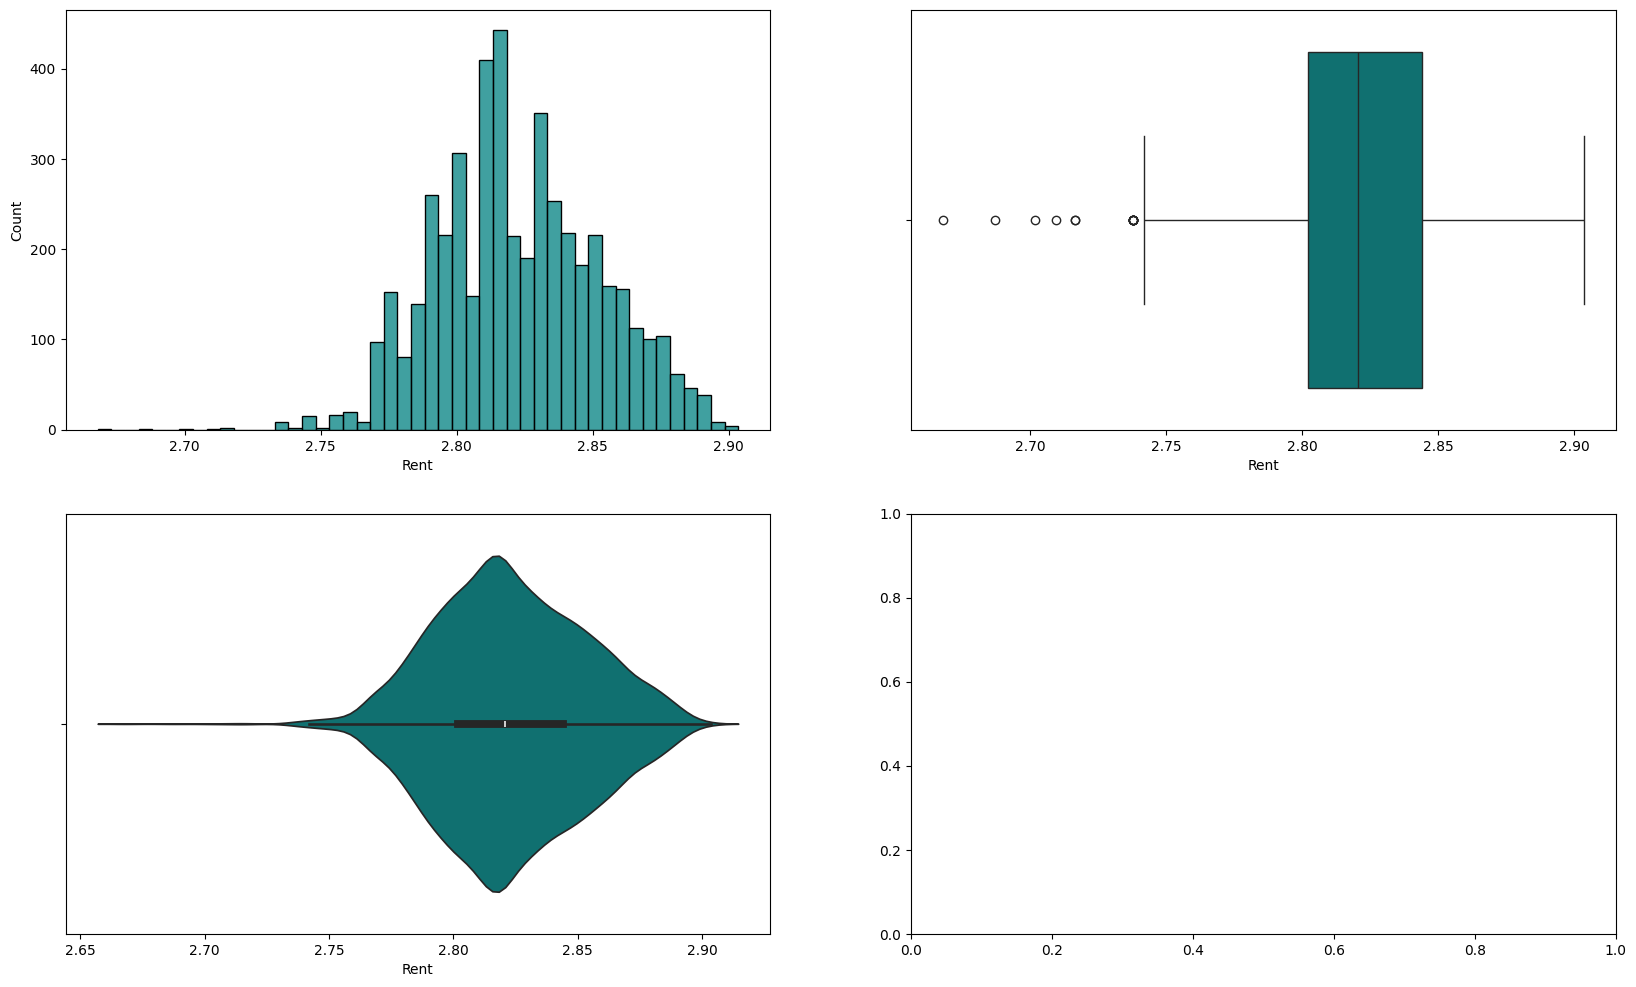

In [457]:
"""
Percebemos que essa coluna tem outliers que precisam ser trabalhados.
Além disso, a distribuição dos dados não está tão agradável para regressão, como a obliquidade e curtose.
Muita variância pode tornar mais difícil de encontrar padrões nos dados.

Primeiro vamos remover os outliers
"""

"""
Para isso vamos utilizar a Box Cox
A Box Cox é uma técnica de normalização para normalizar variáveis 
idependentes que não são normalmente  distribuídas. 
"""

# Remoção dos outliers
max_rent = dataset['Rent'].max()
index_max_rent = dataset[dataset['Rent'] == max_rent].index
dataset = dataset.drop(index_max_rent)

# Box Cox
dataset['Rent'] = boxcox(dataset['Rent'])[0]

# Resultados da aplicação das técnicas
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Rent'], ax= ax[1, 0], color= 'teal')

plt.show()

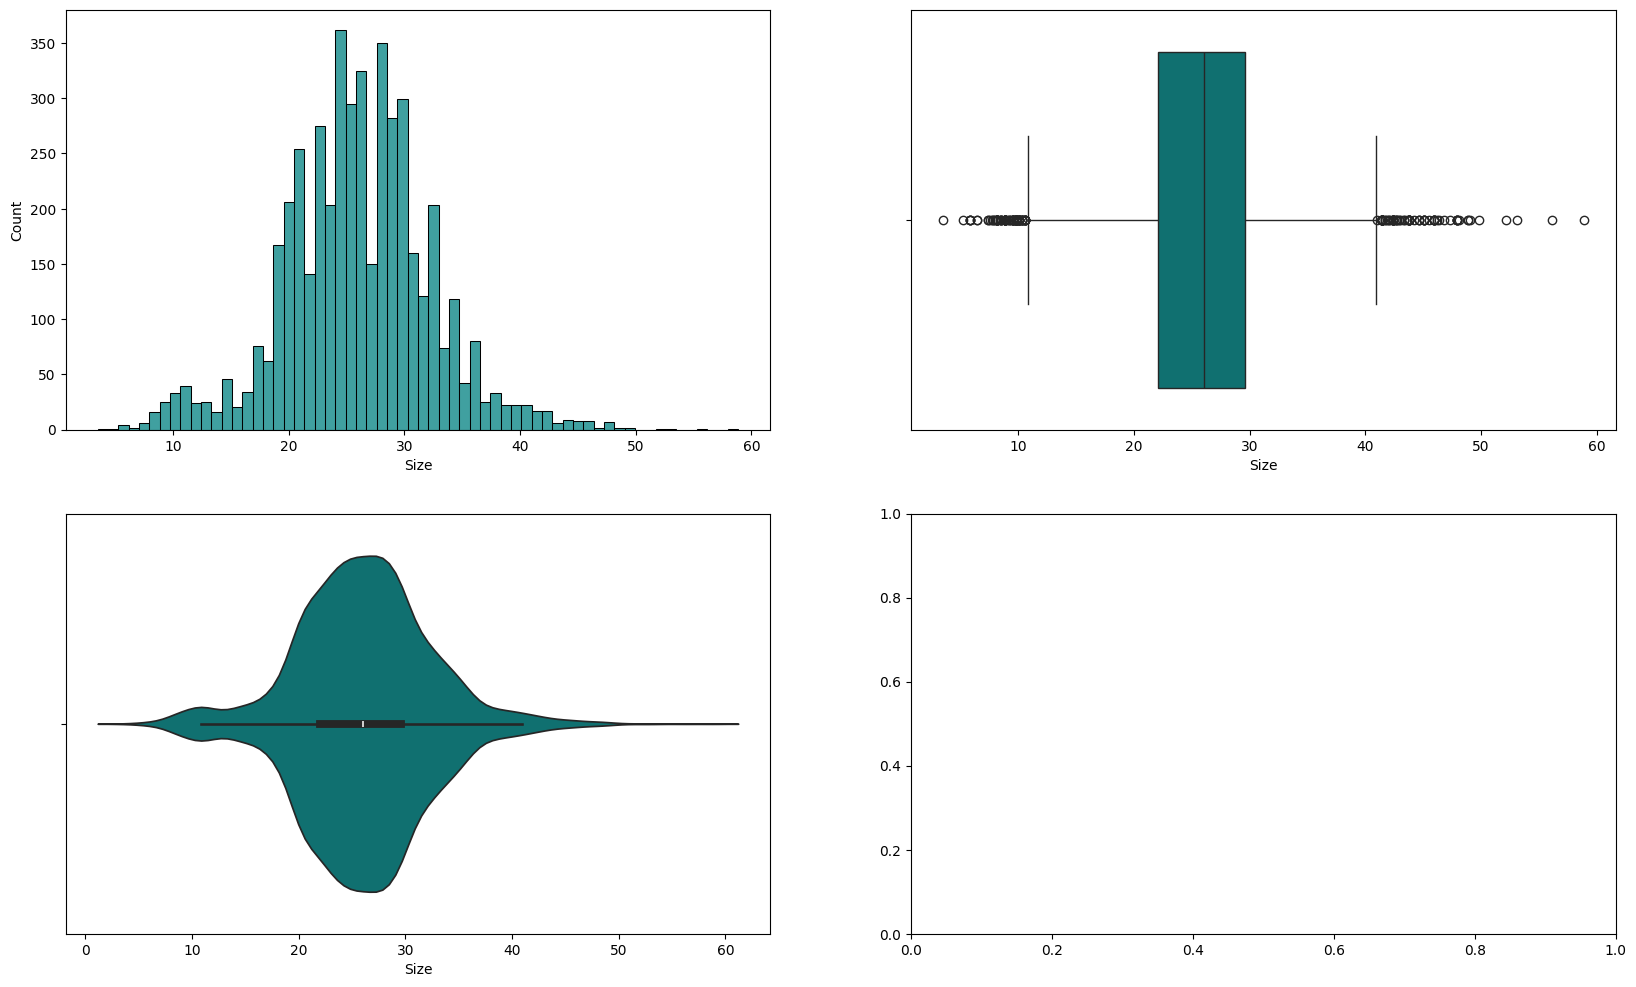

In [458]:
dataset['Size'] = boxcox(dataset['Size'])[0]

# Resultados
ig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Size'], ax= ax[1, 0], color= 'teal')
plt.show()

In [ ]:
# Normalização das colunas 
dataset = dataset.drop_duplicates()

def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

columns = ['Area Type', 'Furnishing Status',  'City', 'Tenant Preferred', 'Point of Contact']
for col in columns:
    dataset = one_hot_encode(dataset, col)

dataset.head()

,BHK,Rent,Size,Bathroom,Carpet Area,Super Area,Semi-Furnished,Unfurnished,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,2,2.802011,28.637808,2,False,True,False,True,False,False,False,True,False
1,2,2.828578,25.411054,1,False,True,True,False,False,False,False,True,False
2,2,2.822901,27.635364,1,False,True,True,False,False,False,False,True,False
3,2,2.802011,25.411054,1,False,True,False,True,False,False,False,True,False
4,2,2.789000,25.998849,1,True,False,False,True,False,False,False,True,False


In [460]:
# Separação dos Dados entre Treino e Teste

X = dataset.drop('Rent', axis= 1)
y = dataset['Rent']

boxcox_result = boxcox(y)
y_boxcox = boxcox_result[0]

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = seed)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape

(3510, 12)

## Modelo

In [461]:
# Treinando Modelo

knn_model = KNeighborsRegressor(n_neighbors = 4)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

In [462]:
#  Avalicação do Modelo

kf = KFold(n_splits= 10)
rmse_result = np.mean(np.sqrt(-cross_val_score(knn_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
mae_result = mean_absolute_error(y_test, knn_pred)
r2_result = r2_score(y_test, knn_pred)

print(f'RMSE {rmse_result:.4f}')
print(f'MAE: {mae_result:.4f}')
print(f'R2: {r2_result:.4f}')

RMSE 0.0161
MAE: 0.0124
R2: 0.7070
